In [1]:
import os
import pathlib

import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Softmax,
)

In [58]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
#CLASS_NAMES = ['1', '2', '5', '10', '20', '50', '100', '200', '500']
CLASS_NAMES = ['10', '100', '20' ,'200', '5' ,'50', '500']
print("These are the available classes:", CLASS_NAMES)


def read_and_decode(filename, reshape_dims):
    """
    Read the image and resize
    # Read the file
    """
    img = tf.io.read_file(filename)
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

    
# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
    """
    
    """
    record_defaults = ["path", "euro"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label


These are the available classes: ['10', '100', '20', '200', '5', '50', '500']


In [59]:
from google.cloud import storage
bucket_name = "team4-project"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
my_prefix='imgs/euro/'
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')
print(blobs)
for blob in blobs:
    print(blob)

<Blob: team4-project, imgs/euro/.DS_Store, 1650537665680586>
<Blob: team4-project, imgs/euro/full_list.csv, 1650755536007673>
<Blob: team4-project, imgs/euro/train_list.csv, 1650755538061964>
<Blob: team4-project, imgs/euro/train_set.csv, 1650622880765520>
<Blob: team4-project, imgs/euro/val_list.csv, 1650755540087673>


In [10]:
!gsutil ls gs://team4-project/
!gsutil ls gs://team4-project/imgs

gs://team4-project/imgs/
gs://team4-project/imgs_processed/
gs://team4-project/imgs/.DS_Store
gs://team4-project/imgs/euro/
gs://team4-project/imgs/usd/


In [89]:
train_set = f"gs://team4-project/imgs/euro/train_data.csv"
eval_data_set=f"gs://team4-project/imgs/euro/val_list.csv"

import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      train_set, eval_set).
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      eval_data_set).
      map(decode_csv)).batch(32)

  layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='Euro_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

model = train_and_evaluate()

Model: "Euro_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 7)                 119       
                                                                 
Total params: 2,278,599
Trainable params: 20,615
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10


ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "mobilenet_embedding" (type KerasLayer).
    
    in user code:
    
        File "/opt/conda/lib/python3.7/site-packages/tensorflow_hub/keras_layer.py", line 237, in call  *
            result = smart_cond.smart_cond(training,
    
        ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
          Positional arguments (4 total):
            * Tensor("inputs:0", shape=(None,), dtype=float32)
            * False
            * False
            * 0.99
          Keyword arguments: {}
        
         Expected these arguments to match one of the following 4 option(s):
        
        Option 1:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
            * True
            * False
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 2:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
            * True
            * True
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 3:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
            * False
            * True
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 4:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
            * False
            * False
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=True


In [17]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 32
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)



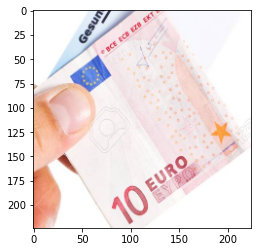

In [18]:
img = tf.io.read_file(
    #"gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg"
    "gs://team4-project/imgs/euro/10/Screen Shot 2019-07-31 at 4.09.05 PM.png"
)

# Uncomment to see the image string.
# print(img)
img = decode_img(img, [IMG_WIDTH, IMG_HEIGHT])
plt.imshow(img.numpy());


In [76]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8


def read_and_preprocess(image_bytes, label, random_augment=False):
    if random_augment:
        img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
        img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, MAX_DELTA)
        img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
    else:
        img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

def decode_csv(csv_row):
    record_defaults = ["path", "euro"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

In [77]:
def load_dataset(csv_of_filenames, batch_size, training=True):
    dataset = (
        tf.data.TextLineDataset(filenames=csv_of_filenames)
        .map(decode_csv)
        .cache()
    )

    if training:
        dataset = (
            dataset.map(read_and_preprocess_with_augment)
            .shuffle(SHUFFLE_BUFFER)
            .repeat(count=None)
        )  # Indefinately.
    else:
        dataset = dataset.map(read_and_preprocess).repeat(
            count=1
        )  # Each photo used once.

    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)

In [78]:
#train_path = "gs://cloud-ml-data/img/flower_photos/train_set.csv"
train_path = "gs://team4-project/imgs/euro/train_list.csv"
train_data = load_dataset(train_path, 1)
itr = iter(train_data)


2022-04-24 07:04:35.572187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2022-04-24 07:04:50.781055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 201 of 320
2022-04-24 07:04:56.468949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


tf.Tensor([ True False False False False False False], shape=(7,), dtype=bool)


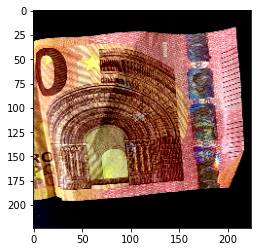

In [79]:
image_batch, label_batch = next(itr)
img = image_batch[0]
plt.imshow(img)
print(label_batch[0])


In [26]:
eval_path = "gs://team4-project/imgs/euro/val_list.csv"
nclasses = len(CLASS_NAMES)
hidden_layer_1_neurons = 400
hidden_layer_2_neurons = 100
dropout_rate = 0.25
num_filters_1 = 64
kernel_size_1 = 3
pooling_size_1 = 2
num_filters_2 = 32
kernel_size_2 = 3
pooling_size_2 = 2

layers = [
    Conv2D(
        num_filters_1,
        kernel_size=kernel_size_1,
        activation="relu",
        input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS),
    ),
    MaxPooling2D(pooling_size_1),
    Conv2D(num_filters_2, kernel_size=kernel_size_2, activation="relu"),
    MaxPooling2D(pooling_size_2),
    Flatten(),
    Dense(hidden_layer_1_neurons, activation="relu"),
    Dense(hidden_layer_2_neurons, activation="relu"),
    Dropout(dropout_rate),
    Dense(nclasses),
    Softmax(),
]

old_model = Sequential(layers)
old_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [27]:
old_model.fit(
    train_ds,
    epochs=5,
    steps_per_epoch=5,
    validation_data=eval_ds,
    validation_steps=VALIDATION_STEPS,
)

Epoch 1/5


2022-04-24 05:45:40.487139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 303 of 320
2022-04-24 05:45:41.008111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5/5 [==============================] - ETA: 0s - loss: 4.0066 - accuracy: 0.2000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 11 batches). You may need to use the repeat() function when building your dataset.


5/5 [==============================] - 32s 5s/step - loss: 4.0066 - accuracy: 0.2000 - val_loss: 1.4416 - val_accuracy: 0.5423
Epoch 2/5
5/5 [==============================] - 8s 2s/step - loss: 1.5821 - accuracy: 0.4250
Epoch 3/5
5/5 [==============================] - 8s 2s/step - loss: 1.4363 - accuracy: 0.5188
Epoch 4/5
5/5 [==============================] - 8s 2s/step - loss: 1.4350 - accuracy: 0.4750
Epoch 5/5
5/5 [==============================] - 8s 2s/step - loss: 1.3239 - accuracy: 0.4563


In [28]:

old_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 400)               3

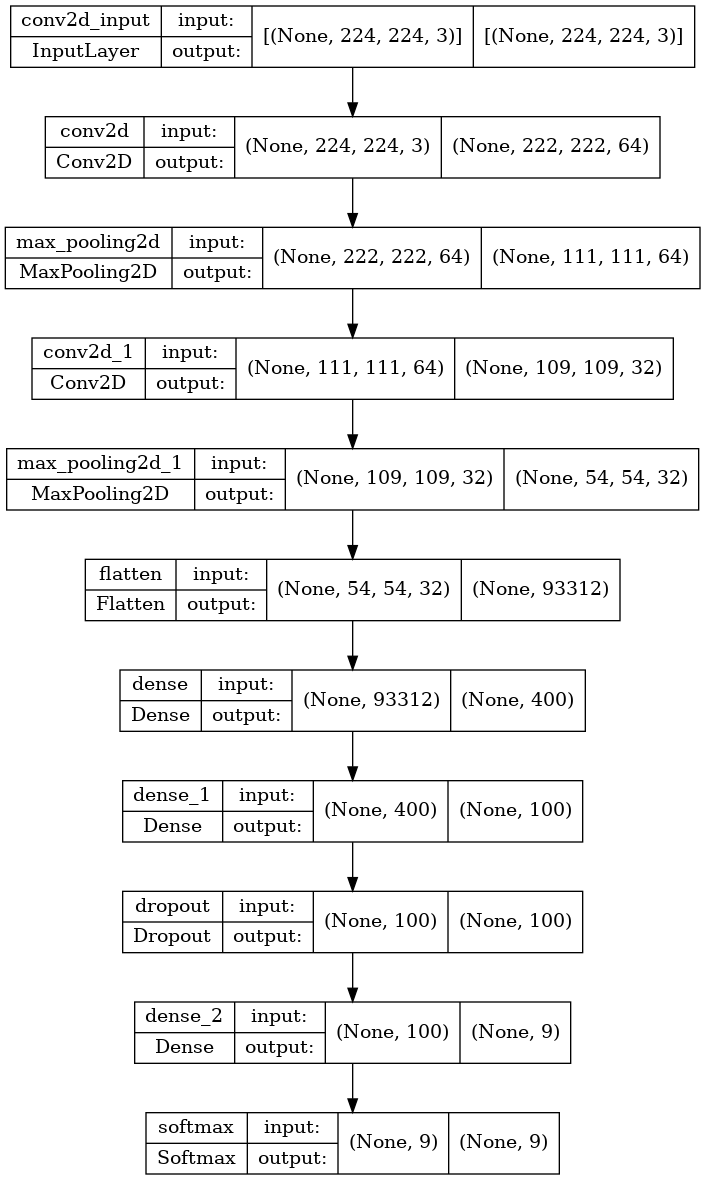

In [87]:
tf.keras.utils.plot_model(old_model, show_shapes=True)

()


ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


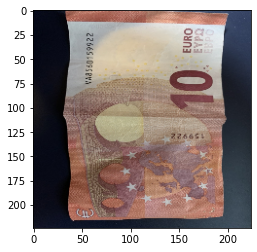

In [88]:
import keras
img = tf.io.read_file(    
    #f"gs://team4-project/imgs/euro/10/Screen Shot 2019-07-31 at 4.09.05 PM.png"
    f"gs://team4-project/imgs/euro/10/IMG_3983 Large.jpeg"
)

print (img.shape)


# Uncomment to see the image string.
# print(img)
img = decode_img(img, [IMG_WIDTH, IMG_HEIGHT])
plt.imshow(img.numpy());

#print (img.reshape(224, 224, 3) )                      
image_size = (IMG_WIDTH, IMG_HEIGHT)

predictions = old_model.predict(img)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

print (old_model.history())


In [ ]:
accuracy = old_model.history["accuracy"]
val_accuracy = old_model.history["val_accuracy"]
loss = old_model.history["loss"]
val_loss = old_model.history["val_loss"]

print (accuracy)
print (val_accuracy)
print (loss)
print (val_loss)

In [29]:
module_selection = "mobilenet_v2_100_224"
module_handle = "https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(
    module_selection
)

transfer_model = tf.keras.Sequential(
    [
        hub.KerasLayer(module_handle, trainable=False),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(
            nclasses,
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
        ),
    ]
)
transfer_model.build((None,) + (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 9)                 11529     
                                                                 
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
transfer_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [31]:
transfer_model.fit(
    train_ds,
    epochs=5,
    steps_per_epoch=5,
    validation_data=eval_ds,
    validation_steps=VALIDATION_STEPS,
)

Epoch 1/5


2022-04-24 05:50:12.949444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 306 of 320
2022-04-24 05:50:13.388639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5/5 [==============================] - ETA: 0s - loss: 1.7629 - accuracy: 0.3812WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 11 batches). You may need to use the repeat() function when building your dataset.


5/5 [==============================] - 31s 4s/step - loss: 1.7629 - accuracy: 0.3812 - val_loss: 1.1855 - val_accuracy: 0.5070
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 1.4588 - accuracy: 0.4812
Epoch 3/5
5/5 [==============================] - 5s 917ms/step - loss: 1.3804 - accuracy: 0.3750
Epoch 4/5
5/5 [==============================] - 5s 1s/step - loss: 1.1428 - accuracy: 0.4875
Epoch 5/5
5/5 [==============================] - 5s 977ms/step - loss: 1.2224 - accuracy: 0.4938


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print("\nTest accuracy:", test_acc)

In [ ]:
%%writefile ../models/util.py

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(7, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(35)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);a
    ax[flower].axis('off')
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)



# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [99]:
%%writefile ../models/train.py

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

CLASS_NAMES = ['10' '100' '20' '200' '5' '50' '500']
train_data_path = "gs://team4-project/imgs/euro/train_set.csv"
eval_data_path = "gs://team4-project/imgs/euro/eval_set.csv"

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3


def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(7, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(35)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);a
    ax[flower].axis('off')


def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)



# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

# parameterize to the values in the previous cell
def train_and_evaluate(train_data_path=f'gs://team4-project/imgs/euro/train_set.csv',
                       eval_data_path=f'gs://team4-project/imgs/euro/eval_set.csv',
                       CLASS_NAMES = ['10' '100' '20' '200' '5' '50' '500'], 
                       batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      train_data_path).
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      eval_data_path).
      map(decode_csv)).batch(32) # this doesn't matter

  layers = [
     
      tf.keras.layers.RandomFlip(),
      tf.keras.layers.RandomRotation(0.1),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),

      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=2)    
  # Save the model    
  model_filename = "model.pkl"
  with open(model_filename, "wb") as model_file:
      pickle.dump(history, model_file)
  gcs_model_path = f"{job_dir}/{model_filename}"
  subprocess.check_call(
     ["gsutil", "cp", model_filename, gcs_model_path], stderr=sys.stdout
  )
  print(f"Saved model in: {gcs_model_path}")


if __name__ == "__main__":
    fire.Fire(train_and_evaluate)



Overwriting ../models/train.py


In [100]:
#Pipeline
from google.cloud import aiplatform
REGION = "us-central1"
PROJECT_ID = !(gcloud config get-value project)
PROJECT_ID = PROJECT_ID[0]
print (PROJECT_ID)

qwiklabs-gcp-00-f30184915a55


In [101]:
# Set `PATH` to include the directory containing KFP CLI
PATH = %env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

env: PATH=/home/jupyter/.local/bin:/home/jupyter/.local/bin:/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games


In [102]:
%%writefile ../models/Dockerfile
FROM gcr.io/deeplearning-platform-release/base-cpu
RUN pip install -U fire cloudml-hypertune scikit-learn==0.20.4 pandas==0.24.2
WORKDIR /app
COPY train.py .

ENTRYPOINT ["python", "train.py"]

Overwriting ../models/Dockerfile


In [94]:
IMAGE_NAME = "cash_classification_vertex"
TAG = "latest"
TRAINING_CONTAINER_IMAGE_URI = f"gcr.io/{PROJECT_ID}/{IMAGE_NAME}:{TAG}"
TRAINING_CONTAINER_IMAGE_URI

'gcr.io/qwiklabs-gcp-00-f30184915a55/cash_classification_vertex:latest'

In [103]:
!gcloud builds submit --timeout 15m --tag $TRAINING_CONTAINER_IMAGE_URI ../models

Creating temporary tarball archive of 3 file(s) totalling 5.5 KiB before compression.
Uploading tarball of [../models] to [gs://qwiklabs-gcp-00-f30184915a55_cloudbuild/source/1650882621.17007-a946322746fb4ecba0c42530257a2474.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/qwiklabs-gcp-00-f30184915a55/locations/global/builds/34001a34-dad8-4f7c-9137-cea13bea5252].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/34001a34-dad8-4f7c-9137-cea13bea5252?project=215824651958].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "34001a34-dad8-4f7c-9137-cea13bea5252"

FETCHSOURCE
Fetching storage object: gs://qwiklabs-gcp-00-f30184915a55_cloudbuild/source/1650882621.17007-a946322746fb4ecba0c42530257a2474.tgz#1650882621452106
Copying gs://qwiklabs-gcp-00-f30184915a55_cloudbuild/source/1650882621.17007-a946322746fb4ecba0c42530257a2474.tgz#1650882621452106...
/ [1 files][  2.4 KiB/  2.4 KiB]                          

In [104]:
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-20:latest"
)

In [105]:
%%writefile ../pipelines/pipeline.py

"""Kubeflow Cash classification Pipeline."""
import os

from kfp import dsl
from training_lightweight_component import train_and_deploy
from tuning_lightweight_component import tune_hyperparameters

PIPELINE_ROOT = os.getenv("PIPELINE_ROOT")
PROJECT_ID = os.getenv("PROJECT_ID")
REGION = os.getenv("REGION")

TRAINING_CONTAINER_IMAGE_URI = os.getenv("TRAINING_CONTAINER_IMAGE_URI")
SERVING_CONTAINER_IMAGE_URI = os.getenv("SERVING_CONTAINER_IMAGE_URI")

TRAINING_FILE_PATH = os.getenv("TRAINING_FILE_PATH")
VALIDATION_FILE_PATH = os.getenv("VALIDATION_FILE_PATH")

MAX_TRIAL_COUNT = int(os.getenv("MAX_TRIAL_COUNT", "5"))
PARALLEL_TRIAL_COUNT = int(os.getenv("PARALLEL_TRIAL_COUNT", "5"))
THRESHOLD = float(os.getenv("THRESHOLD", "0.6"))


@dsl.pipeline(
    name="cash-classification-kfp-pipeline",
    description="The pipeline training and deploying the Cash classifier",
    pipeline_root=PIPELINE_ROOT,
)
def cash_classification_train(
    training_container_uri: str = TRAINING_CONTAINER_IMAGE_URI,
    serving_container_uri: str = SERVING_CONTAINER_IMAGE_URI,
    training_file_path: str = TRAINING_FILE_PATH,
    validation_file_path: str = VALIDATION_FILE_PATH,
    accuracy_deployment_threshold: float = THRESHOLD,
    max_trial_count: int = MAX_TRIAL_COUNT,
    parallel_trial_count: int = PARALLEL_TRIAL_COUNT,
    pipeline_root: str = PIPELINE_ROOT,
):
    staging_bucket = f"{pipeline_root}/staging"

    tuning_op = tune_hyperparameters(
        project=PROJECT_ID,
        location=REGION,
        container_uri=training_container_uri,
        training_file_path=training_file_path,
        validation_file_path=validation_file_path,
        staging_bucket=staging_bucket,
        max_trial_count=max_trial_count,
        parallel_trial_count=parallel_trial_count,
    )

    accuracy = tuning_op.outputs["best_accuracy"]

    with dsl.Condition(
        accuracy >= accuracy_deployment_threshold, name="deploy_decision"
    ):
        train_and_deploy_op = (  # pylint: disable=unused-variable
            train_and_deploy(
                project=PROJECT_ID,
                location=REGION,
                container_uri=training_container_uri,
                serving_container_uri=serving_container_uri,
                training_file_path=training_file_path,
                validation_file_path=validation_file_path,
                staging_bucket=staging_bucket,
                alpha=tuning_op.outputs["best_alpha"],
                max_iter=tuning_op.outputs["best_max_iter"],
            )
        )

Writing ../pipelines/pipeline.py


In [107]:
ARTIFACT_STORE = f"gs://{PROJECT_ID}-kfp-artifact-store"
!gsutil ls | grep ^{ARTIFACT_STORE}/$ || gsutil mb -l {REGION} {ARTIFACT_STORE}

gs://qwiklabs-gcp-00-f30184915a55-kfp-artifact-store/


In [ ]:
ARTIFACT_STORE = f"gs://team4-project"
PIPELINE_ROOT = f"{ARTIFACT_STORE}/pipeline"
DATA_ROOT = f"{ARTIFACT_STORE}/imgs"

TRAINING_FILE_PATH = f"{DATA_ROOT}/euro/train_set.csv"
VALIDATION_FILE_PATH = f"{DATA_ROOT}/euro/eval_set.csv"

%env PIPELINE_ROOT={PIPELINE_ROOT}
%env PROJECT_ID={PROJECT_ID}
%env REGION={REGION}
%env SERVING_CONTAINER_IMAGE_URI={SERVING_CONTAINER_IMAGE_URI}
%env TRAINING_CONTAINER_IMAGE_URI={TRAINING_CONTAINER_IMAGE_URI}
%env TRAINING_FILE_PATH={TRAINING_FILE_PATH}
%env VALIDATION_FILE_PATH={VALIDATION_FILE_PATH}



In [ ]:
PIPELINE_JSON = "cash_kfp_pipeline.json"

In [ ]:
!dsl-compile-v2 --py pipelines/pipeline.py --output $PIPELINE_JSON